# Total Return Swap Pricing and Hedging

In a total return swap, one party makes payments based on a set rate while the other party makes payments based on the return of an underlying asset.

## Utility

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# === DYNAMIC DIVIDEND BUILDER ===
def get_dividend_schedule_auto(ticker_symbol, spot_price, start_date, end_date, months_forward=6, fallback_freq=6):
    ticker = yf.Ticker(ticker_symbol)

    try:
        divs = ticker.dividends
        divs.index = divs.index.tz_localize(None)
        divs = divs[(divs.index >= pd.to_datetime(start_date)) & (divs.index <= pd.to_datetime(end_date))]

        if not divs.empty:
            # Estimate frequency
            dates = divs.index.to_list()
            if len(dates) >= 2:
                gaps = [(dates[i] - dates[i-1]).days for i in range(1, len(dates))]
                avg_gap_months = np.mean(gaps) / 30.44
            else:
                avg_gap_months = fallback_freq

            n_payments = int(months_forward / avg_gap_months)
            latest_div = divs.iloc[-1]
            dividends = [latest_div] * n_payments
            div_times = [avg_gap_months * (i + 1) / 12 for i in range(n_payments)]

            print(f"Used historical dividends from {start_date} to {end_date}. Estimated frequency: {avg_gap_months:.1f} months.")
            return dividends, div_times
    except Exception as e:
        print("Failed to load dividend history:", e)

    # === Fallback: Use dividend yield ===
    try:
        info = ticker.info
        div_yield = info.get("dividendYield", None)
        if div_yield is not None and div_yield > 0:
            forward_annual_div = div_yield * spot_price
            avg_gap_months = fallback_freq
            n_payments = int(months_forward / avg_gap_months)
            dividends = [forward_annual_div / n_payments] * n_payments
            div_times = [avg_gap_months * (i + 1) / 12 for i in range(n_payments)]
            print(f"Used dividend yield fallback. Assumed frequency: {avg_gap_months} months.")
            return dividends, div_times
    except Exception as e:
        print("Failed to load dividend yield info:", e)

    raise ValueError("Failed to retrieve dividend information using both methods.")

## Data Preparation

In [2]:
def data_preparation(ticker, fx_ticker, start_date, end_date, months_forward, notional, funding_rate):
    # Load historical stock data for Tencent (0700.HK)
    tencent_data_og = yf.download(ticker, start=start_date, end=end_date)

    tencent_data = pd.DataFrame()
    tencent_data['Adj_Close'] = tencent_data_og[('Close', ticker)]
    tencent_data['FX_Adj_Close'] = yf.download(fx_ticker, start=start_date, end=end_date)[('Close', fx_ticker)]

    # Calculate daily returns and annualized volatility
    tencent_data['Return'] = tencent_data['Adj_Close'].pct_change()
    tencent_data['FX_Return'] = tencent_data['FX_Adj_Close'].pct_change()

    # Annualized FX volatility (default 0.06)
    fx_vol = np.std(tencent_data['FX_Return'].dropna()) * np.sqrt(252)
    # Annualized stock volatility (default 0.3)
    stock_vol = np.std(tencent_data['Return'].dropna()) * np.sqrt(252)

    # Correlation with stock (default -0.2)
    rho_fx = tencent_data.corr().iloc[1, 3]

    # Current USD/HKD FX rate
    fx_spot = tencent_data['FX_Adj_Close'].iloc[-1]  # USD/HKD
    # Current stock price of Tencent (HKD)
    spot_price = tencent_data['Adj_Close'].iloc[-1]

    # Simulate a dividend schedule
    dividends, div_times = get_dividend_schedule_auto(ticker, spot_price, start_date, end_date, months_forward=6)

    # Simulate FX rate (USD/HKD) using Geometric Brownian Motion
    tenor = months_forward / 12   # forward months in years
    shares = notional / spot_price

    expected_return = tencent_data['Return'].mean() * 252  # Annualized historical return
    
    data_output_df = pd.DataFrame.from_dict({
        "Ticker": ticker,
        "Start Date": start_date,
        "End Date": end_date,
        "Number of Months Forward": months_forward, 
        "Spot Price": spot_price,
        "FX Spot": fx_spot,
        "Stock Vol": stock_vol,
        "FX Vol": fx_vol,
        "Correlation between Returns of Stock and FX": rho_fx,
        "Expected Return": expected_return,
        "Notional if TRS (HKD)": notional,
        "Funding Rate": funding_rate
    }, orient='index', columns=["Value"])

    data_output_df["Value"] = data_output_df["Value"].apply(
        lambda x: f"{x:,.4f}" if isinstance(x, (float, np.number)) else x
    )

    display(HTML(data_output_df.to_html(index=True)))

    # Plot price history and returns
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 5))

    # Plot adjusted close
    tencent_data['Adj_Close'].plot(ax=ax1)
    ax1.set_title("Tencent Adjusted Close Price")
    ax1.set_ylabel("Price (HKD)")

    # Plot returns
    tencent_data['Return'].plot(ax=ax2)
    ax2.set_title("Daily Returns")
    ax2.set_ylabel("Return")
    ax2.axhline(0, color='black', linestyle='--')

    # FX data (USD/HKD)
    # Plot adjusted close
    tencent_data['FX_Adj_Close'].plot(ax=ax3)
    ax3.set_title("FX data (USD/HKD) Adjusted Close Price")
    ax3.set_ylabel("Price (HKD)")

    # Plot returns
    tencent_data['FX_Return'].plot(ax=ax4)
    ax4.set_title("FX data (USD/HKD) Daily Returns")
    ax4.set_ylabel("Return")
    ax4.axhline(0, color='black', linestyle='--')

    plt.tight_layout()
    plt.show()

    return [spot_price, fx_spot, expected_return, tenor, dividends, div_times, shares, rho_fx, stock_vol, fx_vol]

## Price Engine

In [3]:
def price_engine(notional, funding_rate, spot_price, expected_return, tenor, dividends, div_times, shares, rho_fx, stock_vol, fx_vol):    
    # --- Step 1: Compute expected terminal stock price ---
    expected_price_end = spot_price * np.exp(expected_return * tenor)

    # --- Step 2: PV of dividends ---
    div_pv = sum([d * np.exp(-funding_rate * t) for d, t in zip(dividends, div_times)])
    total_div_cashflow = div_pv * shares

    # --- Step 3: Return leg value ---
    capital_gain = (expected_price_end - spot_price) * shares
    return_leg_pv = (capital_gain + total_div_cashflow) * np.exp(-funding_rate * tenor)

    # --- Step 4: Funding leg value ---
    funding_leg_pv = notional * funding_rate * tenor * np.exp(-funding_rate * tenor)

    # --- Step 5: Quanto adjustment (if settled in USD) ---
    quanto_adjustment = -rho_fx * stock_vol * fx_vol
    adjusted_return_leg_pv = return_leg_pv * np.exp(quanto_adjustment * tenor)

    # --- Step 6: Final TRS price (from bank's perspective) ---
    trs_value = adjusted_return_leg_pv - funding_leg_pv

    # Convert values back to float for logic (before string formatting)
    pricing_raw_values = {
        "Expected End Price": expected_price_end,
        "PV of Dividends": total_div_cashflow,
        "Return Leg (HKD)": return_leg_pv,
        "Funding Leg (HKD)": funding_leg_pv,
        "Quanto Adjustment": quanto_adjustment,
        "Adjusted Return Leg": adjusted_return_leg_pv,
        "TRS Value (Bank PnL)": trs_value
    }

    fair_funding_rate = adjusted_return_leg_pv / (notional * tenor * np.exp(-funding_rate * tenor))

    # Generate row-level interpretations
    pricing_interpretations = {
        "Expected End Price": "Projected stock price at maturity under expected return.",
        "PV of Dividends": "Present value of expected dividends over the TRS period.",
        "Return Leg (HKD)": "Gross return from price appreciation + dividends (before FX adjustment).",
        "Funding Leg (HKD)": "Total cost to fund the TRS notional over the tenor.",
        "Quanto Adjustment": (
            "Small impact from FX risk correlation." if abs(quanto_adjustment) < 0.01 
            else "Significant FX correlation impact on pricing."
        ),
        "Adjusted Return Leg": "Return leg after FX quanto adjustment (realistic payout projection).",
        "TRS Value (Bank PnL)": (
            "Net profit for bank from this TRS structure." if trs_value > 0 
            else "Expected loss for bank — return leg is insufficient."
        )
    }
    # Build final DataFrame
    pricing_output_df = pd.DataFrame({
        "Value": [f"{pricing_raw_values[k]:,.4f}" for k in pricing_raw_values],
        "Interpretation": [pricing_interpretations[k] for k in pricing_raw_values]
    }, index=pricing_raw_values.keys())

    # Display nicely
    display(HTML(pricing_output_df.to_html(index=True)))

    return trs_value, fair_funding_rate

## Monte Carlo Simulation

In [4]:
def monte_carlo_sim(funding_rate, tenor, notional, sim_n_steps, sim_n_paths, shares, spot_price, fx_spot, rho_fx, expected_return, stock_vol, fx_vol, dividends, div_times):
    # ======= Simulate Correlated Stock and FX Paths =======
    dt = tenor / sim_n_steps
    np.random.seed(0)

    corr_matrix = np.array([[1, rho_fx],
                            [rho_fx, 1]])
    L = np.linalg.cholesky(corr_matrix)

    # Random shocks for both stock and FX
    Z_uncorr = np.random.normal(0, 1, (sim_n_paths, sim_n_steps, 2))
    Z_corr = Z_uncorr @ L.T  # Shape: (n_paths, n_steps, 2)

    # Initialize paths
    S = np.zeros((sim_n_paths, sim_n_steps + 1))
    FX = np.zeros((sim_n_paths, sim_n_steps + 1))
    S[:, 0] = spot_price
    FX[:, 0] = fx_spot

    # Simulate correlated GBM paths
    for t in range(1, sim_n_steps + 1):
        S[:, t] = S[:, t-1] * np.exp((expected_return - 0.5 * stock_vol**2) * dt + stock_vol * np.sqrt(dt) * Z_corr[:, t-1, 0])
        FX[:, t] = FX[:, t-1] * np.exp(-0.5 * fx_vol**2 * dt + fx_vol * np.sqrt(dt) * Z_corr[:, t-1, 1])

    # ======= Monte Carlo PnL Calculation (Using Pathwise FX Adjustment) =======
    final_prices = S[:, -1]
    final_fx = FX[:, -1]
    fx_change = final_fx / fx_spot  # FX movement factor

    # Discounted dividend stream
    dividend_cashflows = np.zeros(sim_n_paths)
    for div, t in zip(dividends, div_times):
        step = int(t / tenor * sim_n_steps)
        dividend_cashflows += div * np.exp(-funding_rate * t)

    # Return leg with quanto: adjusted using final FX rate
    capital_gains = (final_prices - spot_price) * shares
    return_leg = (capital_gains + dividend_cashflows * shares) * np.exp(-funding_rate * tenor) * fx_change

    # Funding leg: fixed across paths
    funding_leg = notional * funding_rate * tenor * np.exp(-funding_rate * tenor)

    # Final PnL per path (in USD equivalent if fx_change applied)
    trs_pnl_paths = return_leg - funding_leg

    # Plotting with emphasis on dispersion using mean and 1-std shading
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # --- Stock Price Paths ---
    subset_S = S[:500]  # use smaller subset for shading calc
    mean_S = np.mean(subset_S, axis=0)
    std_S = np.std(subset_S, axis=0)

    for i in range(10):
        ax1.plot(S[i], alpha=0.5, color='steelblue')
    ax1.plot(mean_S, label="Mean", color='black', linewidth=2)
    ax1.fill_between(range(len(mean_S)), mean_S - std_S, mean_S + std_S, color='gray', alpha=0.3, label="±1 Std Dev")
    ax1.set_title("Simulated Stock Price Paths (Tencent)")
    ax1.set_xlabel("Trading Days")
    ax1.set_ylabel("Price (HKD)")
    ax1.grid(True)
    ax1.legend()

    # --- FX Rate Paths ---
    subset_FX = FX[:500]
    mean_FX = np.mean(subset_FX, axis=0)
    std_FX = np.std(subset_FX, axis=0)

    for i in range(10):
        ax2.plot(FX[i], alpha=0.5, color='seagreen')
    ax2.plot(mean_FX, label="Mean", color='black', linewidth=2)
    ax2.fill_between(range(len(mean_FX)), mean_FX - std_FX, mean_FX + std_FX, color='gray', alpha=0.3, label="±1 Std Dev")
    ax2.set_title("Simulated USD/HKD FX Rate Paths")
    ax2.set_xlabel("Trading Days")
    ax2.set_ylabel("FX Rate (USD/HKD)")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return S, final_prices, return_leg, funding_leg, trs_pnl_paths

## Dynamic Delta Hedging

In [5]:
def dynamic_delta_hedging(S, shares, trs_pnl_paths, df_sim, rebalance_every=1, use_slippage=False, slippage_rate=0.001):
    """
    Dynamic delta hedging simulation with optional slippage cost and rebalance frequency.
    
    Parameters:
    - S: Simulated stock price paths (n_paths x n_steps+1)
    - shares: Delta exposure (number of shares)
    - trs_pnl_paths: Original TRS PnL paths (n_paths,)
    - df_sim: DataFrame to be updated with hedge results
    - rebalance_every: Rebalance every n days (default=1 for daily)
    - use_slippage: Boolean to include slippage costs
    - slippage_rate: Proportional cost of slippage per hedge unit
    """
    n_paths, n_steps_plus1 = S.shape
    n_steps = n_steps_plus1 - 1

    # Select rebalancing days
    rebalance_idx = np.arange(1, n_steps_plus1, rebalance_every)
    rebalance_idx = rebalance_idx[rebalance_idx < n_steps_plus1]

    # Initialize hedge cost array
    hedge_costs_total = np.zeros(n_paths)

    for i in range(1, len(rebalance_idx)):
        t_prev = rebalance_idx[i - 1]
        t_curr = rebalance_idx[i]

        delta_return = (S[:, t_curr] - S[:, t_prev]) / S[:, t_prev]
        delta_shares = delta_return * shares
        hedge_cost = delta_shares * S[:, t_curr]

        if use_slippage:
            slippage_cost = np.abs(delta_shares) * S[:, t_curr] * slippage_rate
            hedge_cost += slippage_cost

        hedge_costs_total += hedge_cost

    hedge_pnl = -hedge_costs_total
    total_pnl_with_hedge = trs_pnl_paths + hedge_pnl

    # Update df_sim
    df_sim["Hedge PnL"] = hedge_pnl
    df_sim["Total PnL (Hedged)"] = total_pnl_with_hedge

    # Metrics
    vol_unhedged = np.std(df_sim["TRS PnL"])
    vol_hedged = np.std(df_sim["Total PnL (Hedged)"])
    mean_unhedged = np.mean(df_sim["TRS PnL"])
    mean_hedged = np.mean(df_sim["Total PnL (Hedged)"])

    def sharpe_ratio(pnl):
        return np.mean(pnl) / np.std(pnl)

    sharpe_unhedged = sharpe_ratio(df_sim["TRS PnL"])
    sharpe_hedged = sharpe_ratio(df_sim["Total PnL (Hedged)"])

    # PnL Distribution Plot
    plt.figure(figsize=(8, 4))
    plt.hist(df_sim["TRS PnL"], bins=50, alpha=0.6, label="Unhedged TRS PnL")
    plt.hist(df_sim["Total PnL (Hedged)"], bins=50, alpha=0.6, label="Hedged TRS PnL")
    plt.title("TRS PnL Distribution: Hedged vs Unhedged")
    plt.xlabel("PnL")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

    return [df_sim, vol_unhedged, vol_hedged, mean_unhedged, mean_hedged, sharpe_unhedged, sharpe_hedged]

## Evaluation

In [6]:
def evaluation(trs_value, fair_funding_rate, df_sim, vol_unhedged, vol_hedged, mean_unhedged, mean_hedged, sharpe_unhedged, sharpe_hedged):
    trs_pnl_paths = df_sim["TRS PnL"].values
    hedged_pnl_paths = df_sim["Total PnL (Hedged)"].values

    variance_reduction = (vol_unhedged - vol_hedged) / vol_unhedged

    # Tail risk: check skewness (left-skew is negative)
    skew_unhedged = skew(trs_pnl_paths)
    skew_hedged = skew(hedged_pnl_paths)

    if trs_value < 0 and fair_funding_rate < 0:
        print(f"A negative TRS Value ({round(trs_value, 4)}) and negative fair funding rate ({round(fair_funding_rate, 4)}) mean that this TRS is currently unfavorable for the bank unless terms are improved (higher return or lower cost).")
        print("From sell side perspective, consider adjust Funding Rate, Expected Return, or Tenor.")
        print("WARNING: TRS is fundamentally mispriced. Funding costs exceed return leg.")

    # Automated interpretations
    conclusions = {
        "TRS Value (Pricing)": (
            f"{trs_value:,.2f}",
            "✅ Profitable for bank." if trs_value > 0 else (
                "⚠️ Fair pricing: break-even." if abs(trs_value) < 1e4 else "❌ Loss for bank — unprofitable deal.")
        ),
        "PnL Mean (Unhedged)": (
            f"{mean_unhedged:,.2f}",
            "⚠️ High bias — model may be mispriced." if abs(mean_unhedged) > 1e6 else "✅ Acceptable bias."
        ),
        "PnL Mean (Hedged)": (
            f"{mean_hedged:,.2f}",
            "✅ Close to zero — well-neutralized." if abs(mean_hedged) < 1e6 else "⚠️ Hedging not fully neutral."
        ),
        "PnL Std Dev (Unhedged)": (
            f"{vol_unhedged:,.2f}",
            "High dispersion — risky exposure."
        ),
        "PnL Std Dev (Hedged)": (
            f"{vol_hedged:,.2f}",
            "✅ Reduced volatility post-hedging." if vol_hedged < vol_unhedged else "❌ Volatility increased — ineffective hedge."
        ),
        "Sharpe Ratio (Unhedged)": (
            f"{sharpe_unhedged:.2f}",
            "Low reward-to-risk."
        ),
        "Sharpe Ratio (Hedged)": (
            f"{sharpe_hedged:.2f}",
            "✅ Improved risk-adjusted return." if sharpe_hedged > sharpe_unhedged else "❌ No improvement in Sharpe."
        ),
        "Variance Reduction %": (
            f"{variance_reduction:.2%}",
            "✅ Effective variance suppression." if variance_reduction > 0.6 else "⚠️ Partial risk reduction."
        ),
        "Tail Skew (Unhedged)": (
            f"{skew_unhedged:.2f}",
            "⚠️ Left-skewed — downside risk present." if skew_unhedged < -0.5 else "✅ Symmetric distribution."
        ),
        "Tail Skew (Hedged)": (
            f"{skew_hedged:.2f}",
            "✅ Reduced skew — hedge helps stabilize." if skew_hedged > skew_unhedged else "⚠️ Skew persists after hedge."
        )
    }

    summary_df = pd.DataFrame(conclusions, index=["Metric Value", "Interpretation"]).T
    display(summary_df)

    return summary_df

## Overall Pipeline

In [7]:
def pipeline(ticker, fx_ticker, start_date, end_date, months_forward, notional, funding_rate, sim_n_steps=126, sim_n_paths=10000, rebalance_every=1, use_slippage=False, slippage_rate=0.001):
    print('\n==============================')
    print('Data And Assumptions')
    print('==============================\n')

    output_list = data_preparation(ticker, fx_ticker, start_date, end_date, months_forward, notional, funding_rate)
    spot_price, fx_spot, expected_return, tenor, dividends, div_times, shares, rho_fx, stock_vol, fx_vol = output_list
    
    print('\n==============================')
    print('Price Engine')
    print('==============================\n')

    trs_value, fair_funding_rate = price_engine(notional, funding_rate, spot_price, expected_return, tenor, dividends, div_times, shares, rho_fx, stock_vol, fx_vol)

    print('\n==============================')
    print('Monte Carlo Simulation')
    print('==============================\n')

    output_list = monte_carlo_sim(funding_rate, tenor, notional, sim_n_steps, sim_n_paths, shares, spot_price, fx_spot, rho_fx, expected_return, stock_vol, fx_vol, dividends, div_times)
    S, final_prices, return_leg, funding_leg, trs_pnl_paths = output_list

    # Package into DataFrame
    df_sim = pd.DataFrame({
        "Final Stock Price": final_prices,
        "Return Leg": return_leg,
        "Funding Leg": funding_leg,
        "TRS PnL": trs_pnl_paths
    })
    
    print('\n==============================')
    print('Dynamic Delta Hedging')
    print('==============================\n')

    output_list = dynamic_delta_hedging(S, shares, trs_pnl_paths, df_sim, rebalance_every, use_slippage, slippage_rate)
    df_sim, vol_unhedged, vol_hedged, mean_unhedged, mean_hedged, sharpe_unhedged, sharpe_hedged = output_list

    print('\n==============================')
    print('Performance Evaluation')
    print('==============================\n')

    evaluation(trs_value, fair_funding_rate, df_sim, vol_unhedged, vol_hedged, mean_unhedged, mean_hedged, sharpe_unhedged, sharpe_hedged)

## Examples

### Tencent

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data And Assumptions



Used historical dividends from 2023-01-01 to 2025-01-01. Estimated frequency: 12.0 months.


,Value
Ticker,0700.HK
Start Date,2023-01-01
End Date,2025-01-01
Number of Months Forward,6
Spot Price,419.8000
FX Spot,7.7635
Stock Vol,0.3267
FX Vol,0.0076
Correlation between Returns of Stock and FX,0.1159
Expected Return,0.1892


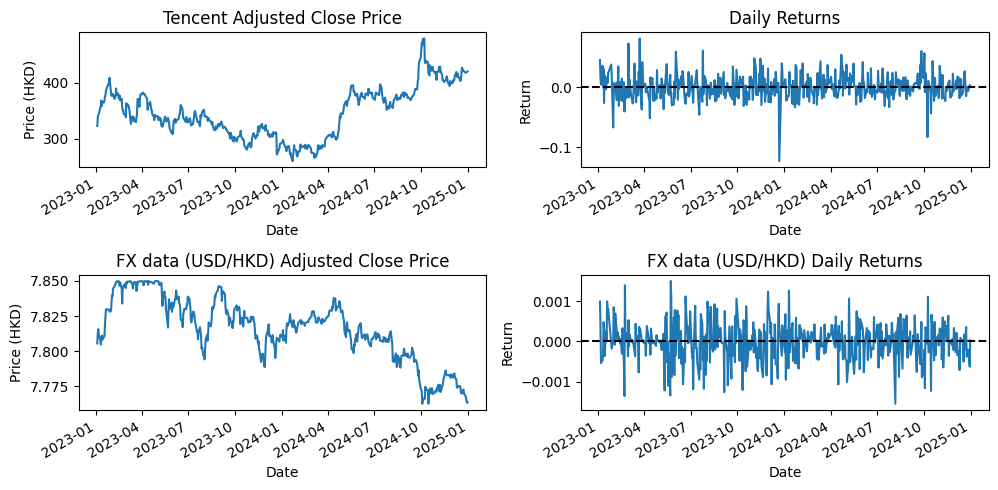


Price Engine



,Value,Interpretation
Expected End Price,461.4627,Projected stock price at maturity under expected return.
PV of Dividends,0.0000,Present value of expected dividends over the TRS period.
Return Leg (HKD),"4,851,808.6495",Gross return from price appreciation + dividends (before FX adjustment).
Funding Leg (HKD),"1,099,970.1418",Total cost to fund the TRS notional over the tenor.
Quanto Adjustment,-0.0003,Small impact from FX risk correlation.
Adjusted Return Leg,"4,851,110.7926",Return leg after FX quanto adjustment (realistic payout projection).
TRS Value (Bank PnL),"3,751,140.6508",Net profit for bank from this TRS structure.



Monte Carlo Simulation



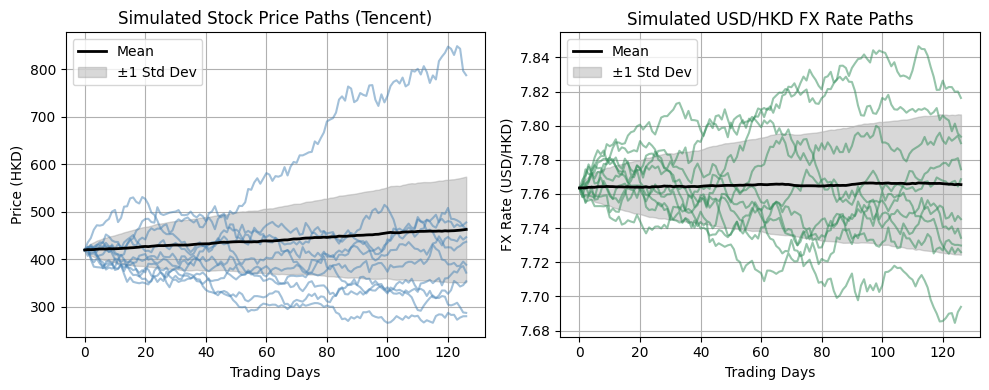


Dynamic Delta Hedging



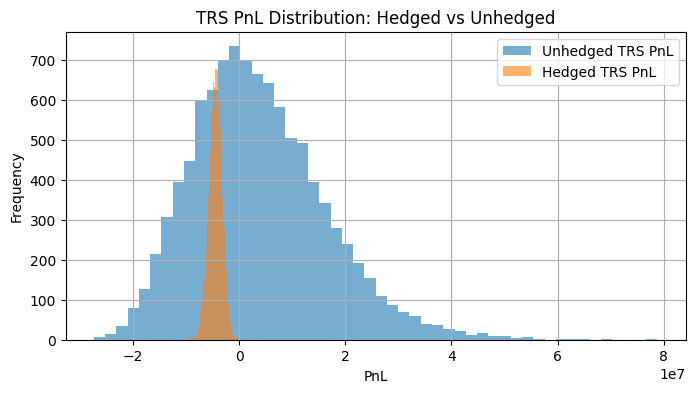


Performance Evaluation



,Metric Value,Interpretation
TRS Value (Pricing),"3,751,140.65",✅ Profitable for bank.
PnL Mean (Unhedged),"3,744,116.29",⚠️ High bias — model may be mispriced.
PnL Mean (Hedged),"-4,484,523.16",⚠️ Hedging not fully neutral.
PnL Std Dev (Unhedged),"12,599,773.83",High dispersion — risky exposure.
PnL Std Dev (Hedged),"1,253,062.65",✅ Reduced volatility post-hedging.
Sharpe Ratio (Unhedged),0.30,Low reward-to-risk.
Sharpe Ratio (Hedged),-3.58,❌ No improvement in Sharpe.
Variance Reduction %,90.05%,✅ Effective variance suppression.
Tail Skew (Unhedged),0.68,✅ Symmetric distribution.
Tail Skew (Hedged),-0.20,⚠️ Skew persists after hedge.


In [19]:
pipeline(ticker="0700.HK", 
         fx_ticker="HKD=X", 
         start_date="2023-01-01", 
         end_date="2025-01-01", 
         months_forward=6, 
         notional=50_000_000, 
         funding_rate=0.045, 
         sim_n_steps=126, 
         sim_n_paths=10000, 
         rebalance_every=1, 
         use_slippage=True, 
         slippage_rate=0.005)

### T

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


Data And Assumptions



Used historical dividends from 2024-01-01 to 2025-01-01. Estimated frequency: 6.0 months.


,Value
Ticker,0700.HK
Start Date,2024-01-01
End Date,2025-01-01
Number of Months Forward,12
Spot Price,419.8000
FX Spot,7.7635
Stock Vol,0.2974
FX Vol,0.0067
Correlation between Returns of Stock and FX,0.1293
Expected Return,0.4105


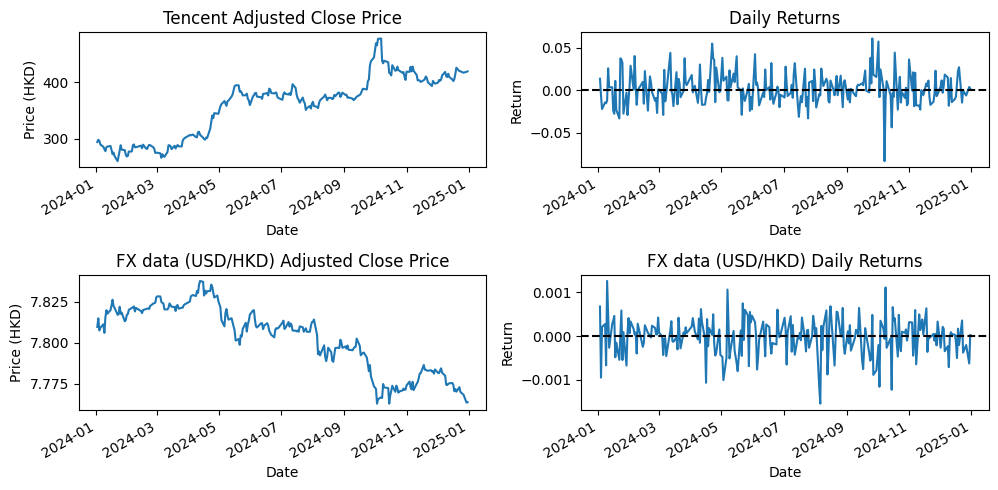


Price Engine



,Value,Interpretation
Expected End Price,632.8931,Projected stock price at maturity under expected return.
PV of Dividends,"395,945.0099",Present value of expected dividends over the TRS period.
Return Leg (HKD),"24,642,036.0475",Gross return from price appreciation + dividends (before FX adjustment).
Funding Leg (HKD),"2,150,994.3341",Total cost to fund the TRS notional over the tenor.
Quanto Adjustment,-0.0003,Small impact from FX risk correlation.
Adjusted Return Leg,"24,635,721.3756",Return leg after FX quanto adjustment (realistic payout projection).
TRS Value (Bank PnL),"22,484,727.0415",Net profit for bank from this TRS structure.



Monte Carlo Simulation



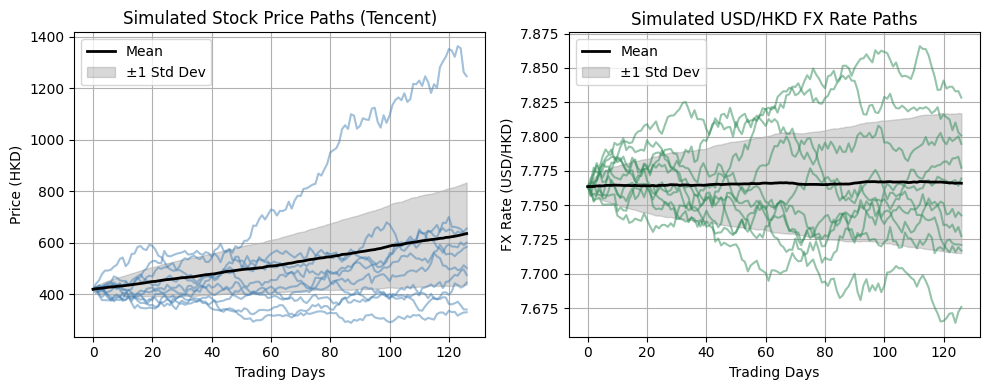


Dynamic Delta Hedging



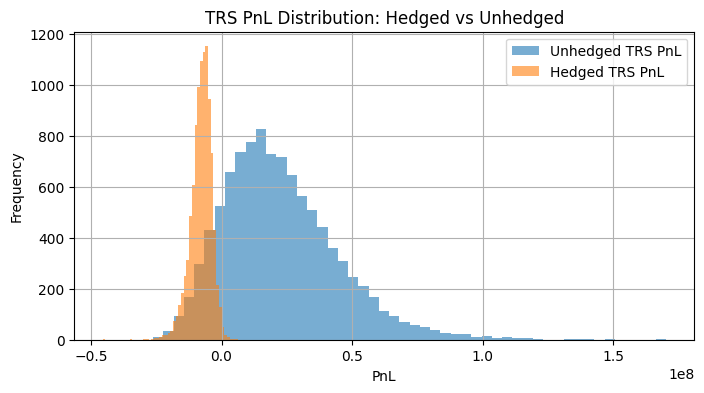


Performance Evaluation



,Metric Value,Interpretation
TRS Value (Pricing),"22,484,727.04",✅ Profitable for bank.
PnL Mean (Unhedged),"22,486,088.60",⚠️ High bias — model may be mispriced.
PnL Mean (Hedged),"-7,849,056.73",⚠️ Hedging not fully neutral.
PnL Std Dev (Unhedged),"21,934,368.47",High dispersion — risky exposure.
PnL Std Dev (Hedged),"3,978,803.27",✅ Reduced volatility post-hedging.
Sharpe Ratio (Unhedged),1.03,Low reward-to-risk.
Sharpe Ratio (Hedged),-1.97,❌ No improvement in Sharpe.
Variance Reduction %,81.86%,✅ Effective variance suppression.
Tail Skew (Unhedged),0.91,✅ Symmetric distribution.
Tail Skew (Hedged),-0.85,⚠️ Skew persists after hedge.


In [37]:
pipeline(ticker="0700.HK", 
         fx_ticker="HKD=X", 
         start_date="2024-01-01", 
         end_date="2025-01-01", 
         months_forward=12, 
         notional=50_000_000, 
         funding_rate=0.045, 
         sim_n_steps=126, 
         sim_n_paths=10000, 
         rebalance_every=3, 
         use_slippage=False, 
         slippage_rate=0.0001)